In [1]:
from time import sleep

def inc(x):
    sleep(1)
    return x + 1

def add(x, y):
    sleep(1)
    return x + y

First let's make some toy functions, inc and add, that sleep for a while to simulate work. We'll then time running these functions normally

In [2]:
%%time
# This takes three seconds to run because we call each
# function sequentially, one after the other

x = inc(1)
y = inc(2)
z = add(x, y)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3 s


In [3]:
from dask import delayed

In [4]:
%%time
# This runs immediately, all it does is build a graph

x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 320 µs


In [5]:
%%time
# This actually runs our computation using a local thread pool

z.compute()

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2 s


5

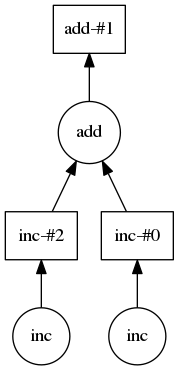

In [6]:
z.visualize()

#### actually x and y calculated on the same time!

In [7]:
data = [1, 2, 3, 4, 5, 6, 7, 8]

In [8]:
%%time
# Sequential code

results = []
for no, x in enumerate(data):
    y = inc(x)
    print('sleep 1s at:',no)
    results.append(y)
    
total = sum(results)
print('total sum:',total)

sleep 1s at: 0
sleep 1s at: 1
sleep 1s at: 2
sleep 1s at: 3
sleep 1s at: 4
sleep 1s at: 5
sleep 1s at: 6
sleep 1s at: 7
total sum: 44
CPU times: user 8 ms, sys: 8 ms, total: 16 ms
Wall time: 8.01 s


In [9]:
%%time
# with dask

results = []
for no, x in enumerate(data):
    y = delayed(inc)(x)
    print('sleep 1s at:',no)
    results.append(y)
    
total = delayed(sum)(results)
print("Before computing:", total)  # Let's see what type of thing total is
result = total.compute()
print("After computing :", result)  # After it's computed

sleep 1s at: 0
sleep 1s at: 1
sleep 1s at: 2
sleep 1s at: 3
sleep 1s at: 4
sleep 1s at: 5
sleep 1s at: 6
sleep 1s at: 7
Before computing: Delayed('sum-a54e9529-cf7d-4872-a13f-524f4cb8cf8e')
After computing : 44
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 2.01 s


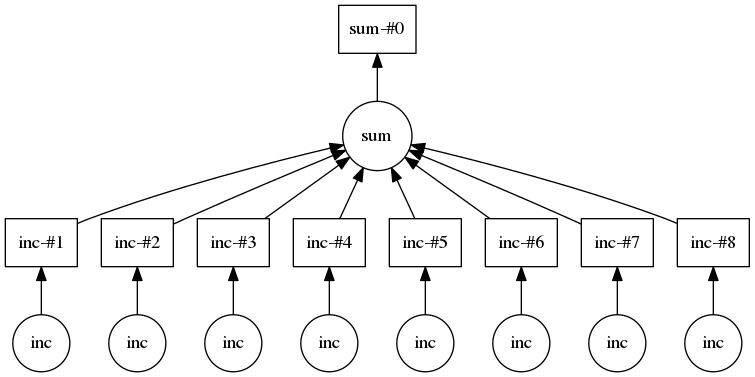

In [10]:
total.visualize()

In [11]:
def double(x):
    sleep(1)
    return 2 * x

def is_even(x):
    return not x % 2

data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [12]:
%%time
# Sequential code

results = []
for no, x in enumerate(data):
    if is_even(x):
        y = double(x)
    else:
        y = inc(x)
    print('sleep 1s at:',no)
    results.append(y)
    
total = sum(results)
print('total sum:',total)

sleep 1s at: 0
sleep 1s at: 1
sleep 1s at: 2
sleep 1s at: 3
sleep 1s at: 4
sleep 1s at: 5
sleep 1s at: 6
sleep 1s at: 7
sleep 1s at: 8
sleep 1s at: 9
total sum: 90
CPU times: user 16 ms, sys: 4 ms, total: 20 ms
Wall time: 10 s


In [13]:
%%time
# with dask

results = []
for no, x in enumerate(data):
    if is_even(x):
        y = delayed(double)(x)
    else:
        y = delayed(inc)(x)
    print('sleep 1s at:',no)
    results.append(y)
    
total = delayed(sum)(results)
print("Before computing:", total)  # Let's see what type of thing total is
result = total.compute()
print("After computing :", result)  # After it's computed

sleep 1s at: 0
sleep 1s at: 1
sleep 1s at: 2
sleep 1s at: 3
sleep 1s at: 4
sleep 1s at: 5
sleep 1s at: 6
sleep 1s at: 7
sleep 1s at: 8
sleep 1s at: 9
Before computing: Delayed('sum-c2b2dee8-7a6d-4f4e-991b-3f97ff7048ef')
After computing : 90
CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 3.01 s


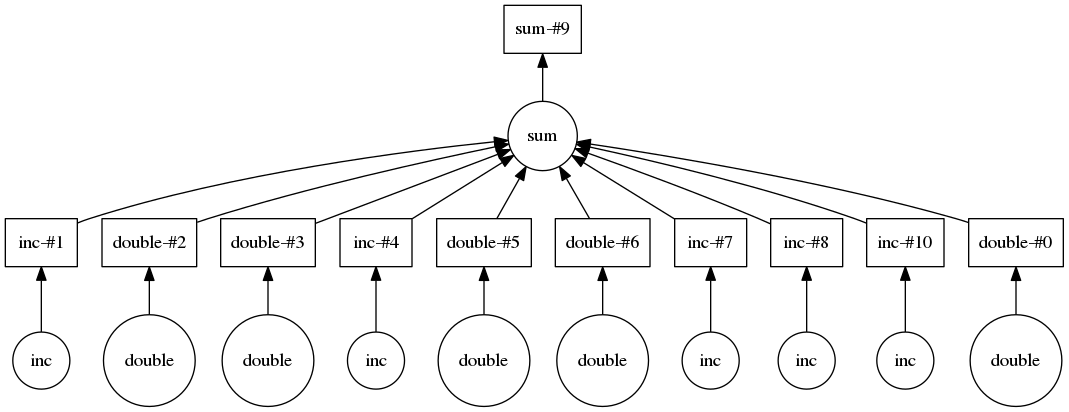

In [14]:
total.visualize()

In [15]:
import os
import numpy as np
import pandas as pd
from glob import glob
import tarfile
import urllib.request
import zipfile

data_dir = 'data'

if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
flights_raw = os.path.join(data_dir, 'nycflights.tar.gz')
flightdir = os.path.join(data_dir, 'nycflights')
jsondir = os.path.join(data_dir, 'flightjson')

if not os.path.exists(flights_raw):
    print("- Downloading NYC Flights dataset... ", end='', flush=True)
    url = "https://storage.googleapis.com/dask-tutorial-data/nycflights.tar.gz"
    urllib.request.urlretrieve(url, flights_raw)
    print("done", flush=True)

if not os.path.exists(flightdir):
    print("- Extracting flight data... ", end='', flush=True)
    tar_path = os.path.join(data_dir, 'nycflights.tar.gz')
    with tarfile.open(tar_path, mode='r:gz') as flights:
        flights.extractall('data/')
    print("done", flush=True)

if not os.path.exists(jsondir):
    print("- Creating json data... ", end='', flush=True)
    os.mkdir(jsondir)
    for path in glob(os.path.join(data_dir, 'nycflights', '*.csv')):
        prefix = os.path.splitext(os.path.basename(path))[0]
        # Just take the first 10000 rows for the demo
        df = pd.read_csv(path).iloc[:10000]
        df.to_json(os.path.join(data_dir, 'flightjson', prefix + '.json'),orient='records', lines=True)
    print("done", flush=True)

In [16]:
list_flights = sorted(os.listdir(os.path.join('data', 'nycflights')))
list_flights

['1990.csv',
 '1991.csv',
 '1992.csv',
 '1993.csv',
 '1994.csv',
 '1995.csv',
 '1996.csv',
 '1997.csv',
 '1998.csv',
 '1999.csv']

In [17]:
df = pd.read_csv(os.path.join('data', 'nycflights', list_flights[0]))
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990,1,1,1,1621.0,1540,1747.0,1701,US,33,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990,1,2,2,1547.0,1540,1700.0,1701,US,33,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990,1,3,3,1546.0,1540,1710.0,1701,US,33,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990,1,4,4,1542.0,1540,1710.0,1701,US,33,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990,1,5,5,1549.0,1540,1706.0,1701,US,33,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


In [18]:
df.Origin.unique()

array(['EWR', 'LGA', 'JFK'], dtype=object)

In [19]:
df.groupby('Origin').DepDelay.mean()

Origin
EWR     9.168411
JFK    11.857274
LGA     8.560045
Name: DepDelay, dtype: float64

In [20]:
%%time

sums = []
counts = []
total_row = 0
for fn in list_flights:
    # Read in file
    df = pd.read_csv(os.path.join('data', 'nycflights', fn))
    total_row += df.shape[0]
    
    # Groupby origin airport
    by_origin = df.groupby('Origin')
    
    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()
    
    # Number of flights by origin
    count = by_origin.DepDelay.count()
    
    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights
print('total delays:',total_delays)
print('no flights:',n_flights)
print('mean of delays:',mean)
print('total rows calculated:',total_row)

total delays: Origin
EWR    11731182.0
JFK     4422520.0
LGA     7239916.0
Name: DepDelay, dtype: float64
no flights: Origin
EWR    1139451
JFK     427243
LGA     974267
Name: DepDelay, dtype: int64
mean of delays: Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64
total rows calculated: 2611892
CPU times: user 3.51 s, sys: 68 ms, total: 3.58 s
Wall time: 3.57 s


In [21]:
%%time

sums = []
counts = []
total_row = 0
for fn in list_flights:
    # Read in file
    df = delayed(pd.read_csv)(os.path.join('data', 'nycflights', fn))
    total_row += df.shape[0]
    
    # Groupby origin airport
    by_origin = df.groupby('Origin')
    
    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()
    
    # Number of flights by origin
    count = by_origin.DepDelay.count()
    
    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
total_delays = delayed(sum)(sums)
n_flights = delayed(sum)(counts)
total_delays_compute = total_delays.compute()
n_flights_compute = n_flights.compute()
mean = total_delays_compute / n_flights_compute
print('total delays:',total_delays_compute)
print('no flights:',n_flights_compute)
print('mean of delays:',mean)
print('total rows calculated:',total_row.compute())

total delays: Origin
EWR    11731182.0
JFK     4422520.0
LGA     7239916.0
Name: DepDelay, dtype: float64
no flights: Origin
EWR    1139451
JFK     427243
LGA     974267
Name: DepDelay, dtype: int64
mean of delays: Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64
total rows calculated: 2611892
CPU times: user 13.5 s, sys: 476 ms, total: 14 s
Wall time: 5.02 s


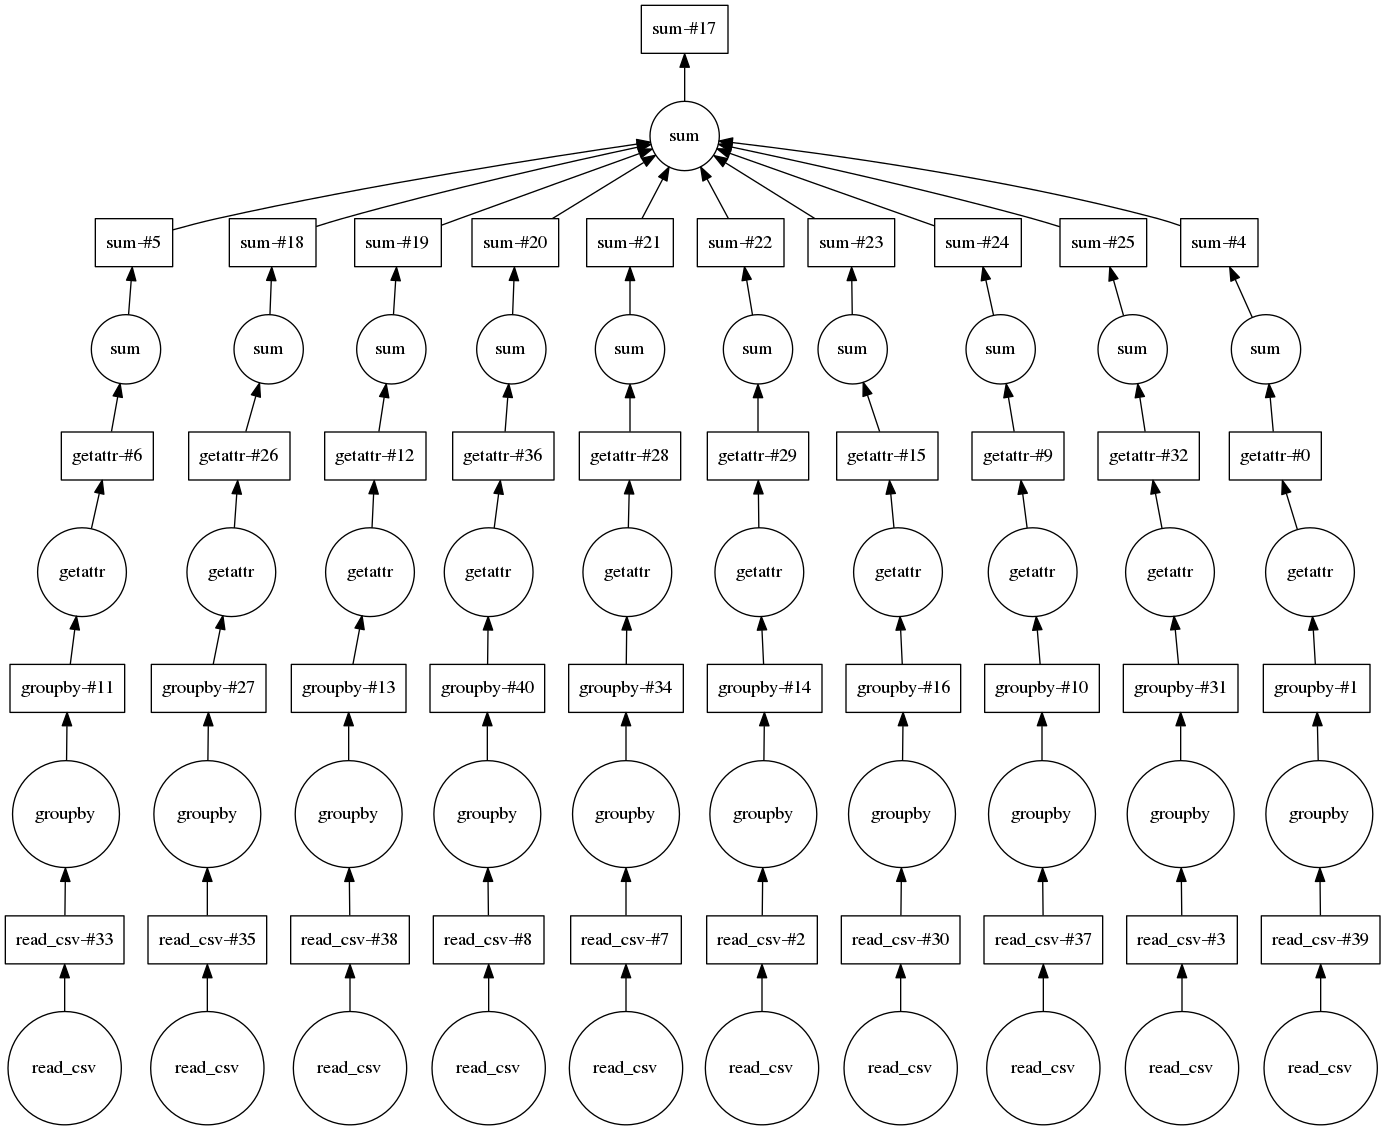

In [22]:
total_delays.visualize()

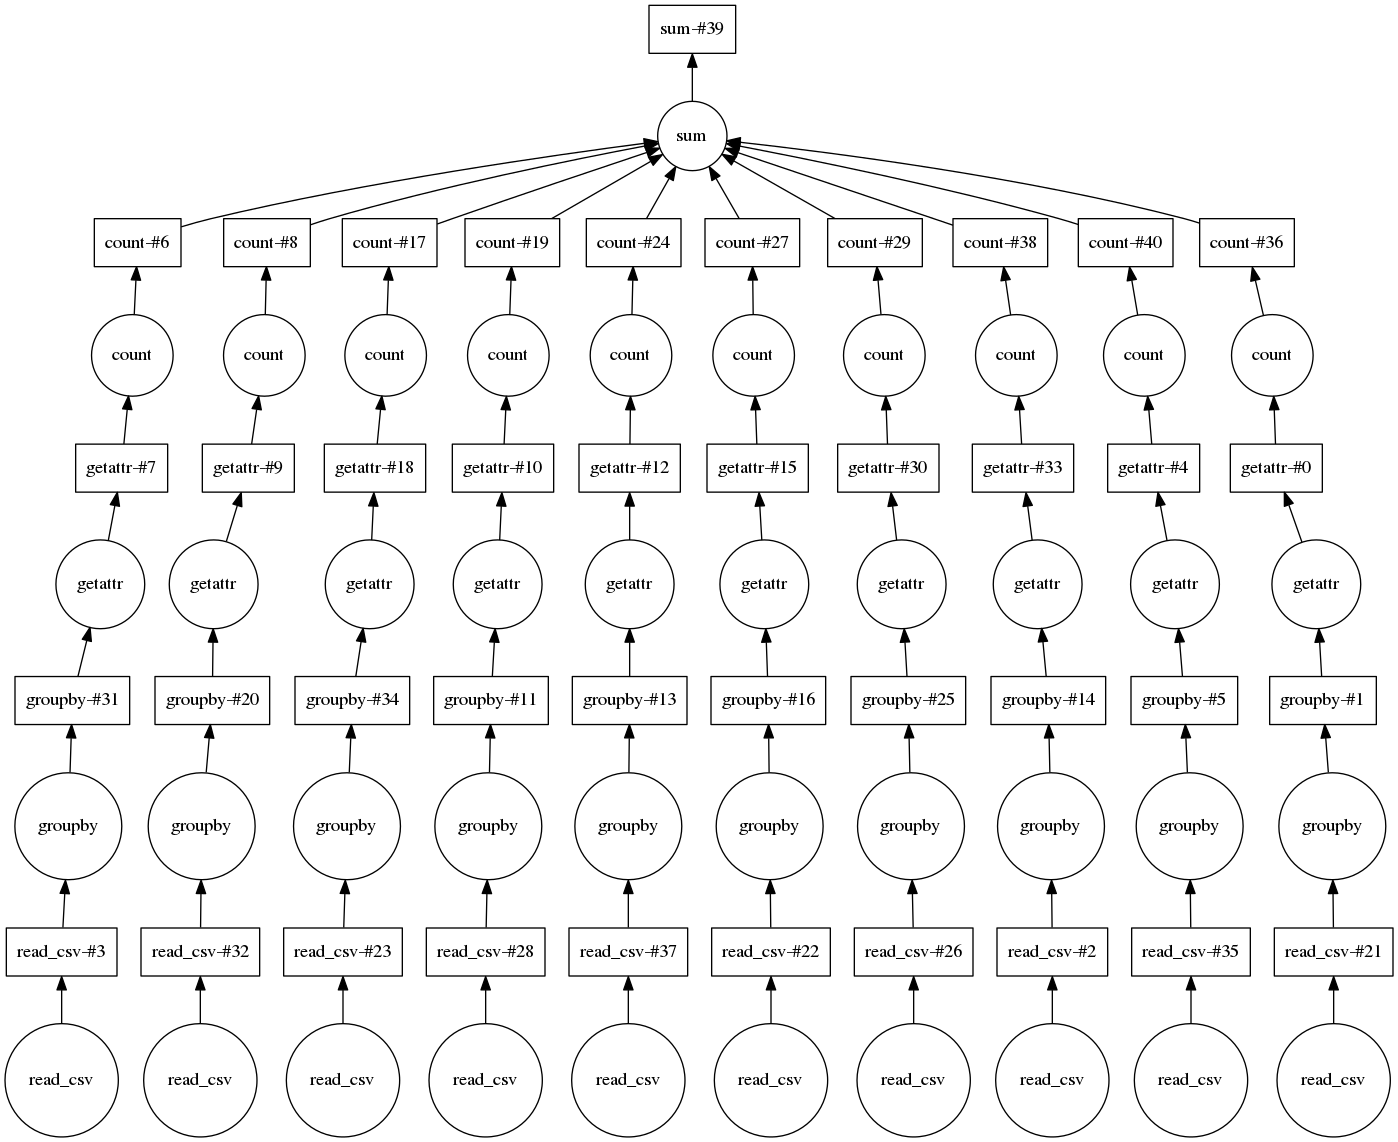

In [23]:
n_flights.visualize()

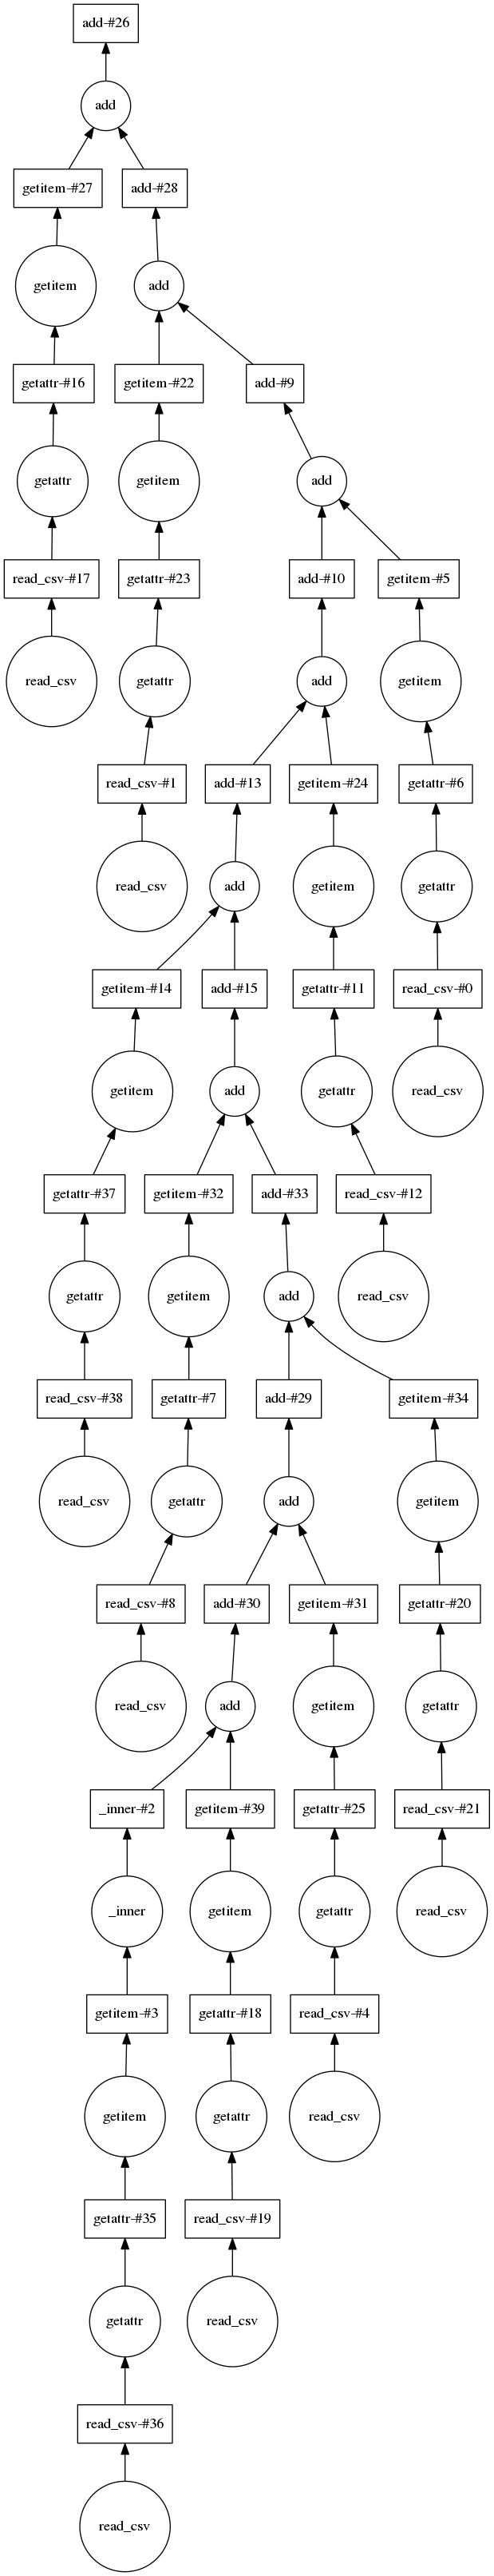

In [24]:
total_row.visualize()

In [25]:
from dask import compute

In [26]:
%%time

sums = []
counts = []
total_row = 0
for fn in list_flights:
    # Read in file
    df = delayed(pd.read_csv)(os.path.join('data', 'nycflights', fn))
    total_row += df.shape[0]
    
    # Groupby origin airport
    by_origin = df.groupby('Origin')
    
    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()
    
    # Number of flights by origin
    count = by_origin.DepDelay.count()
    
    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
sums, counts = compute(sums, counts)

total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights
print('total delays:',total_delays)
print('no flights:',n_flights)
print('mean of delays:',mean)
print('total rows calculated:',total_row.compute())

total delays: Origin
EWR    11731182.0
JFK     4422520.0
LGA     7239916.0
Name: DepDelay, dtype: float64
no flights: Origin
EWR    1139451
JFK     427243
LGA     974267
Name: DepDelay, dtype: int64
mean of delays: Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64
total rows calculated: 2611892
CPU times: user 9.18 s, sys: 276 ms, total: 9.46 s
Wall time: 3.38 s
